# Messung von Q2 mit QFP1 Annealing

In [1]:
%matplotlib inline
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import cmath
from scipy.special import gamma, factorial
from qiskit.quantum_info.states.utils import (_funm_svd)
#import multiprocessing as mp

In [2]:
# Parameter

N = 27
xi = .39
m = 1/(4 * xi**2)
omega_qfp = 2 * xi
omega_r = 1.2 * omega_qfp
delta = omega_r-omega_qfp

toq1 = 0.09; toqfp1 = 1/toq1
toq2 = 0.12; toqfp2 = 1/toq2

eps1 = toq1*omega_qfp
eps2 = toq2*omega_qfp

eta = m*omega_qfp

# rde1, rde2: Delta/epsilon von Qubits. Normalerweise Delta<epsilon

In [3]:
def parameter(rde2, rdg, rj):
    
    rde1 = rde2
    
    rde1_eff = rde1 * np.exp(-eta)
    rde2_eff = rde2 * np.exp(-eta)
    
    Del1 = eps1 * rde1
    Del2 = eps2 * rde2
    
    Del1_eff = eps1 * rde1_eff
    Del2_eff = eps2 * rde2_eff
    
    omega_q1 = eps1 * np.sqrt(1+rde1**2)
    omega_q2 = eps2 * np.sqrt(1+rde2**2)
    
    J = (omega_q2-omega_q1)*rj #1/20
    
    omega_eff1 = toqfp1 * eps1 * np.sqrt(1+rde1_eff**2)
    omega_eff2 = toqfp2 * eps2 * np.sqrt(1+rde2_eff**2)
    
    delta_eff1 = omega_r - omega_eff1
    delta_eff2 = omega_r - omega_eff2
    
    theta_eff1 = np.arctan(rde1_eff)
    theta_eff2 = np.arctan(rde2_eff)
    
    g = delta/rdg
    
    g1 = g*np.sin(theta_eff1)
    g2 = g*np.sin(theta_eff2)
    #g_eff = g1*g2*(delta_eff1+delta_eff2)/(delta_eff1*delta_eff2)
    #chi1 = g1**2/delta_eff1
    chi2 = g2**2/delta_eff2
    
    return (J, chi2, theta_eff1, theta_eff2, delta_eff1, delta_eff2)


In [4]:
z1 = tensor(sigmaz(), qeye(2), identity(N))
z2 = tensor(qeye(2), sigmaz(), identity(N))
x1 = tensor(sigmax(), qeye(2), identity(N))
x2 = tensor(qeye(2), sigmax(), identity(N))
zz = tensor(sigmaz(), sigmaz(), identity(N))
xz = tensor(sigmax(), sigmaz(), identity(N))
zx = tensor(sigmaz(), sigmax(), identity(N))
xx = tensor(sigmax(), sigmax(), identity(N))
yy = tensor(sigmay(), sigmay(), identity(N))
a = tensor(qeye(2), qeye(2), destroy(N))

In [5]:
def Hamilton(rde2, rdg, alpha, rj):
    
    (J, chi2, theta_eff1, \
     theta_eff2, delta_eff1, delta_eff2) = parameter(rde2, rdg, rj)
    
    J*=(toqfp1+toqfp2)/2
    
    
    delta1_n = delta_eff1
    #delta1_n = ((delta_eff1  + chi1) + 2*chi1*a.dag()*a)
    delta2_n = ((delta_eff2  + chi2) + 2*chi2*a.dag()*a)
    delta1_0 = delta_eff1
    delta2_0 = delta_eff2 + chi2
    
    Jzz = J * np.cos(theta_eff1) * np.cos(theta_eff2)
    Jzx = J * np.cos(theta_eff1) * np.sin(theta_eff2)
    Jxz = J * np.sin(theta_eff1) * np.cos(theta_eff2)
    Jxx = J * np.sin(theta_eff1) * np.sin(theta_eff2)
    
    Hf = - delta1_n/2 * (np.cos(theta_eff1)*z1+np.sin(theta_eff1)*x1)\
    - delta2_n/2 * (np.cos(theta_eff2)*z2+np.sin(theta_eff2)*x2)+ J*zz # Fluss Basis
    
    H3 = - delta1_n/2 * z1 - delta2_n/2 * z2 + Jzz*zz -Jzx*zx -Jxz*xz + Jxx*xx
    
    # unter der Bedingung $|\cos(\theta_{\text{eff,2}})|, |\cos(\theta_1)| 
    # >> |\sin(\theta_{\text{eff,2}})|, |\sin(\theta_1)|$:
    # theta2 < pi/4
    
    w0 = np.sqrt((delta1_0-delta2_0)**2/4)
    sin0 = 0
    cos0 = 1
    
    H3zzb = - delta1_n/2 * z1 - delta2_n/2 * z2 + Jzz*zz    # bare
    
    # unter der Bedingung $|\cos(\theta_{\text{eff,2}})|, |\cos(\theta_1)| 
    # << |\sin(\theta_{\text{eff,2}})|, |\sin(\theta_1)|$:
    # theta1: (pi/2.5, pi/2); theta2: (pi/2.1, pi/2)
    
    H3xxb = - delta1_n/2 * z1 - delta2_n/2 * z2 + Jxx*xx
    
    omega30p = cmath.sqrt(Jxx**2 + (delta1_0+delta2_0)**2/4)
    omega30m = cmath.sqrt(Jxx**2+(delta1_0-delta2_0)**2/4)
    cos30p = (delta1_0+delta2_0)/(2*omega30p)
    sin30p = Jxx/ omega30p
    cos30m = (delta1_0-delta2_0)/(2*omega30m)
    sin30m = Jxx/omega30m
    
    H3xxd = -1/2*((delta2_n+delta1_n) * cos30p - Jxx*sin30p)*(z1+z2)\
    +1/2*((delta2_n+delta1_n) * sin30p + Jxx*cos30p) *(xx-yy)\
    +1/2*((delta1_n-delta2_n)*cos30m+Jxx*sin30m) *(z1-z2)\
    +1/2*(Jxx*cos30m - (delta1_n-delta2_n)*sin30m)*(xx+yy) # dressed Basis
    
    return (chi2, Hf, H3, H3zzb, H3xxb, H3xxd)

In [6]:
def odd (n):
    if (n % 2) == 0:
        return 0
    else:
        return 1

In [7]:
def fid_norm(opr1, opr2):
    
    s1sq = _funm_svd(opr1, np.sqrt)
    s2sq = _funm_svd(opr2, np.sqrt)
    fid = np.linalg.norm(s1sq.dot(s2sq), ord='nuc')**2
    
    #fid = np.linalg.norm(opr1.sqrtm()*opr2.sqrtm(), ord='nuc')**2
    
    return float(np.real(fid))

In [8]:
zus00 = ket("00")
zus01 = ket("01")
zus10 = ket("10")
zus11 = ket("11")

#psi0q1 = (basis(2, 0) + basis(2, 1)).unit()
#psi0q2 = (basis(2, 0) + basis(2, 1)).unit()
psi0_q = (zus00+zus01+zus10+zus11).unit()

rho0_q = ket2dm(psi0_q)
rho0_q1 = psi0_q.ptrace(0)
rho0_q2 = psi0_q.ptrace(1)

In [9]:
def ideal_pm(S):
    
    if np.sign(S) == 1:
            
        Mid = (zus00 * zus00.dag()+zus10 * zus10.dag()) * rho0_q * (zus00 * zus00.dag()+zus10 * zus10.dag())
        
    elif np.sign(S) == -1:
        Mid = (zus01 * zus01.dag()+zus11 * zus11.dag()) * rho0_q * (zus01 * zus01.dag()+zus11 * zus11.dag())
    
    return Mid

In [10]:
def ideal():
      
    ideal_p = ideal_pm(1)
    ideal_m = ideal_pm(-1)
    
    Fid = (ideal_p+ideal_m).ptrace(1)
    
    return Fid

In [11]:
def Mess_pm(H, t, alpha, S):
   
    nsteps = 1000
    while not 'U' in locals():
        try:
            U = propagator(H, t, options = Options(num_cpus=5, atol=1e-8, nsteps=nsteps))
        except:
            nsteps *= 10
            if nsteps>10000000:
                raise SystemExit('nsteps too large')
    
    #U = propagator(H, t, options = Options(atol=1e-10, rtol = 1e-08, nsteps=10000000))
    
    F = 0
    
    for l in range(0, N):
        for k in range(0, N):
            fcl = tensor(qeye(2), qeye(2), fock(N, l))
            fck = tensor(qeye(2), qeye(2), fock(N, k))
 
            if l == k:
        
                e = np.exp(-alpha**2)* alpha **(2*l)/(2 * factorial(l))\
                * (fcl.dag()* U * fcl) * rho0_q * (fcl.dag() * U * fcl)
                    
            else:
                e = (-np.sign(S) * np.exp(-alpha**2)) * (1j/np.pi) * alpha **(l+k) \
                * gamma((l+k)/2 + 1)* odd(k-l)/(factorial(k) * factorial(l)*(k-l)) \
                * (fcl.dag() * U * fcl) * rho0_q * (fck.dag() * U * fck)
                     
            F += e
    
    return F

In [12]:
def Mess(H, t, alpha):
    
    M_p = Mess_pm(H, t, alpha, 1)
    M_m = Mess_pm(H, t, alpha, -1)
    
    M = (M_p+M_m).ptrace(1)
    
    return M

In [13]:
def fid(H, t, alpha):
    
    M = Mess(H, t, alpha)
    M_id = ideal()
    
    F = fid_norm(M, M_id)
    
    return F

In [14]:
def main(rde2, rdg, alpha, rtc, rj):
    
    oper = Hamilton(rde2, rdg, alpha, rj)
    
    t = rtc/np.absolute(oper[0])
    
    F = [fid(oper[i], t, alpha) for i in range(1, 4)]

    return F

In [15]:
def mainxx(rde2, rdg, alpha, rtc, rj):
    
    oper = Hamilton(rde2, rdg, alpha, rj)
    
    t = rtc/np.absolute(oper[0])
    
    F = [fid(oper[i], t, alpha) for i in range(4, len(oper))]

    return F

In [16]:
rj_list = np.linspace(.005, .1, 20)

In [17]:
(rde2, rde2xx, rdg, alpha, rtc) =(1, 10, 8, 1, np.pi/2)

In [18]:
%time F_rj = [main(rde2, rdg, alpha, rtc, rj) for rj in rj_list]

/home/shiji/anaconda3/envs/qutip-env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1012: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


CPU times: user 42min 53s, sys: 1min 9s, total: 44min 3s
Wall time: 23min 37s


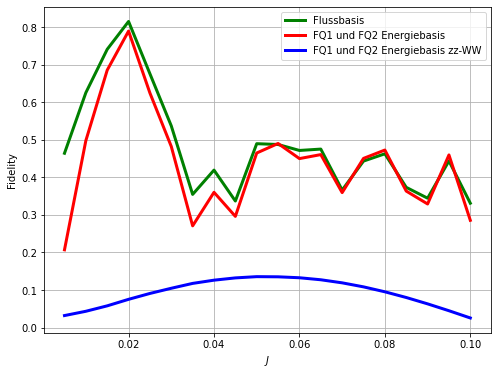

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

#ax.plot(alpha_list, [f[0] for f in F_alp], 'g', label='Flussbasis', linewidth=3)

ax.plot(rj_list, [f[0] for f in F_rj], 'g', label='Flussbasis', linewidth=3)
ax.plot(rj_list, [f[1] for f in F_rj], 'r', label='FQ1 und FQ2 Energiebasis', linewidth=3)
ax.plot(rj_list, [f[2] for f in F_rj], 'b', label='FQ1 und FQ2 Energiebasis zz-WW', linewidth=3)

#ax.plot(alpha_list, [f[0] for f in F_alpzz], 'r', label='FQ1 und FQ2 Energiebasis', linewidth=3)
#ax.plot(alpha_list, [f[1] for f in F_alpzz], label='FQ1 und FQ2 Energiebasis zz-WW', linewidth=3)

#ax.set_xlim(0, 3)
ax.set_xlabel(r'$J$')
ax.set_ylabel('Fidelity')
ax.legend(loc=1)
ax.grid(True)

plt.savefig('2qm_J.pdf')